In [9]:
# Imports and setup
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm

# Optional imports
try:
    import torch
except Exception:
    torch = None

try:
    import trimesh
except Exception:
    trimesh = None

try:
    from PIL import Image
except Exception:
    Image = None

# Try PyVista (VTK wrapper) for high-quality mesh rendering
try:
    import pyvista as pv
except Exception:
    pv = None

# Thesis-friendly plot style
plt.rcParams.update(
    {
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 11,
        "axes.labelsize": 11,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)


def _clean_3d_axes(ax, hide_axes=False):
    ax.grid(False)
    # Transparent panes
    ax.xaxis.pane.set_edgecolor("white")
    ax.yaxis.pane.set_edgecolor("white")
    ax.zaxis.pane.set_edgecolor("white")
    ax.xaxis.pane.set_alpha(0.0)
    ax.yaxis.pane.set_alpha(0.0)
    ax.zaxis.pane.set_alpha(0.0)
    if hide_axes:
        try:
            ax.set_axis_off()
        except Exception:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])


def set_equal_aspect_3d(ax):
    """Set equal aspect for 3D axes."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    plot_radius = 0.5 * max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def plot_point_cloud(ax, points, color="#1f77b4", s=0.5, alpha=0.9, hide_axes=False):
    ax.scatter(
        points[:, 0],
        points[:, 1],
        points[:, 2],
        s=s,
        c=color,
        alpha=alpha,
        depthshade=True,
    )
    set_equal_aspect_3d(ax)
    _clean_3d_axes(ax, hide_axes=hide_axes)


def plot_mesh(
    ax,
    vertices,
    faces,
    face_color=None,
    edge_color=None,
    alpha=1.0,
    max_faces=80000,
    seed=0,
    hide_axes=False,
    colormap="viridis",
    color_by="z",  # 'z' (height) or None
    wireframe=True,
    wire_color=(0, 0, 0, 1.0),
    wire_width=0.4,
):
    """Plot mesh with optional face downsampling and per-face colormap plus black wireframe edges."""
    faces = np.asarray(faces)
    if faces.shape[0] > max_faces:
        rng = np.random.default_rng(seed)
        idx = rng.choice(faces.shape[0], size=max_faces, replace=False)
        faces = faces[idx]

    tris = vertices[faces]

    # Color handling
    if color_by == "z":
        centroids = tris.mean(axis=1)
        z_vals = centroids[:, 2]
        z_min, z_max = float(np.min(z_vals)), float(np.max(z_vals))
        denom = (z_max - z_min) if (z_max - z_min) > 1e-9 else 1.0
        t = (z_vals - z_min) / denom
        cmap = cm.get_cmap(colormap)
        face_colors = cmap(t)
        face_colors[:, 3] = alpha
    else:
        base = face_color if face_color is not None else "#DDDDDD"
        base_rgba = list(plt.matplotlib.colors.to_rgba(base))
        base_rgba[3] = alpha
        face_colors = np.tile(base_rgba, (tris.shape[0], 1))

    poly = Poly3DCollection(tris, facecolors=face_colors)
    if wireframe and wire_color is not None:
        poly.set_edgecolor(wire_color)
        poly.set_linewidth(wire_width)
    else:
        if edge_color is not None:
            poly.set_edgecolor(edge_color)
        else:
            poly.set_edgecolor((0, 0, 0, 0))
    ax.add_collection3d(poly)

    mins = vertices.min(axis=0)
    maxs = vertices.max(axis=0)
    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    set_equal_aspect_3d(ax)
    _clean_3d_axes(ax, hide_axes=hide_axes)


def plot_voxels(
    ax, occ, max_cubes=40000, color="#2ca02c", edge_color=(0, 0, 0, 0), hide_axes=False
):
    occ = np.asarray(occ).astype(bool)

    def downsample_to_limit(occ, limit):
        if occ.sum() <= limit:
            return occ
        step = 1
        while True:
            step += 1
            ds = occ[::step, ::step, ::step]
            if ds.sum() <= limit or min(ds.shape) < 4:
                return ds

    occ_ds = downsample_to_limit(occ, max_cubes)

    xs, ys, zs = np.indices(np.array(occ_ds.shape) + 1)
    ax.voxels(xs, ys, zs, occ_ds, facecolors=color, edgecolor=edge_color)

    ax.set_xlim(0, occ_ds.shape[0])
    ax.set_ylim(0, occ_ds.shape[1])
    ax.set_zlim(0, occ_ds.shape[2])
    set_equal_aspect_3d(ax)
    _clean_3d_axes(ax, hide_axes=hide_axes)


def add_label(ax, text, loc=(0.02, 0.98), color="black", fontsize=None):
    if fontsize is None:
        base = plt.rcParams.get("font.size", 11)
        fontsize = base * 1.5
    if hasattr(ax, "text2D"):
        ax.text2D(
            loc[0],
            loc[1],
            text,
            transform=ax.transAxes,
            ha="left",
            va="top",
            color=color,
            fontsize=fontsize,
        )
    else:
        ax.text(
            loc[0],
            loc[1],
            text,
            transform=ax.transAxes,
            ha="left",
            va="top",
            color=color,
            fontsize=fontsize,
        )


def extract_pollen_id(stem: str) -> str:
    name = Path(stem).stem
    if "_" in name and name.split("_")[0].isdigit():
        return name.split("_")[0]
    return name


# --- VTK/PyVista offscreen mesh renderer ---


def mesh_image_vtk(
    vertices: np.ndarray,
    faces: np.ndarray,
    elev: float = 20.0,
    azim: float = -60.0,
    image_size=(800, 800),
    face_color="#DDDDDD",
    smooth_shading=True,
    show_edges=True,
    edge_color="black",
    edge_width=0.6,
    max_faces: int = 120_000,
):
    """Render a mesh using PyVista/VTK offscreen and return an RGBA image (numpy array).

    - vertices: (N,3) float
    - faces: (M,3) int
    - elev/azim: viewing angles, aligned with Matplotlib semantics
    - image_size: (w,h)
    - face_color: base face color
    - show_edges/edge_color/edge_width: wireframe overlay
    - max_faces: random downsampling for performance
    """
    if pv is None:
        raise RuntimeError("PyVista/VTK not available")

    verts = np.asarray(vertices)
    fcs = np.asarray(faces)
    if fcs.shape[1] != 3:
        raise ValueError("Faces must be triangular (M,3)")

    # Downsample faces for speed if needed
    if fcs.shape[0] > max_faces:
        rng = np.random.default_rng(0)
        sel = rng.choice(fcs.shape[0], size=max_faces, replace=False)
        fcs = fcs[sel]

    # Build PyVista mesh: faces need a leading 3 per face and flattened
    fcs_pv = np.hstack(
        [np.full((fcs.shape[0], 1), 3, dtype=np.int64), fcs.astype(np.int64)]
    )
    fcs_pv = fcs_pv.ravel()
    mesh = pv.PolyData(verts, fcs_pv)

    plotter = pv.Plotter(
        off_screen=True, window_size=(int(image_size[0]), int(image_size[1]))
    )
    plotter.set_background(
        "white"
    )  # background goes transparent in screenshot(..., transparent=True)
    plotter.add_mesh(
        mesh,
        color=face_color,
        smooth_shading=smooth_shading,
        show_edges=show_edges,
        edge_color=edge_color,
        line_width=edge_width,
        ambient=0.2,
        specular=0.1,
        specular_power=10.0,
        metallic=0.0,
    )

    # Camera: derive from bounds and elev/azim similar to Matplotlib
    xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
    cx, cy, cz = (0.5 * (xmin + xmax), 0.5 * (ymin + ymax), 0.5 * (zmin + zmax))
    size = max(xmax - xmin, ymax - ymin, zmax - zmin)
    radius = 0.5 * size if size > 0 else 1.0
    dist = 2.2 * radius

    er = np.deg2rad(elev)
    ar = np.deg2rad(azim)
    cam_pos = (
        cx + dist * np.cos(er) * np.cos(ar),
        cy + dist * np.cos(er) * np.sin(ar),
        cz + dist * np.sin(er),
    )
    plotter.camera_position = [cam_pos, (cx, cy, cz), (0, 0, 1)]
    plotter.enable_anti_aliasing("fxaa")

    img = plotter.screenshot(transparent=True)
    plotter.close()

    # Ensure RGBA uint8
    if img.dtype != np.uint8:
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    return img


print(
    "Setup loaded. torch=",
    getattr(torch, "__version__", None),
    "trimesh=",
    getattr(trimesh, "__version__", None),
)

Setup loaded. torch= 2.7.1+cpu trimesh= 4.6.1


In [10]:
# Paths and data loading
voxel_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\voxels\17781_Common_thyme_Thymus_vulgaris_pollen_grain.pt"
pointcloud_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\pointclouds\17781_Common_thyme_Thymus_vulgaris_pollen_grain.npz"
mesh_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\interim\17781_Common_thyme_Thymus_vulgaris_pollen_grain.stl"
image_path = r"C:\Users\super\Documents\Github\sequoia\data\pollen_augmented\pollen_test\17781_Common_thyme_Thymus_vulgaris_pollen_grain\rgb\000000.png"

# Second object: Daisy (Bellis perennis)
mesh2_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\interim\17818_Common_daisy_Bellis_perennis_pollen_grain.stl"
voxel2_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\voxels\17818_Common_daisy_Bellis_perennis_pollen_grain.pt"
pointcloud2_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\pointclouds\17818_Common_daisy_Bellis_perennis_pollen_grain.npz"
image2_path = r"C:\Users\super\Documents\Github\sequoia\data\processed\pixelnerf\pollen\pollen_train\17818_Common_daisy_Bellis_perennis_pollen_grain\rgb\000000.png"

# Existence checks
for p in [
    voxel_path,
    pointcloud_path,
    mesh_path,
    image_path,
    mesh2_path,
    voxel2_path,
    pointcloud2_path,
    image2_path,
]:
    if not Path(p).exists():
        print(f"Warning: Path not found: {p}")

# Load voxels (torch .pt -> numpy bool)
voxels = voxels2 = None
if torch is not None and Path(voxel_path).exists():
    data = torch.load(voxel_path, map_location="cpu")
    if isinstance(data, dict):
        for key in ["voxels", "occupancy", "grid", "data"]:
            if key in data:
                voxels = data[key]
                break
        if voxels is None:
            try:
                voxels = next(iter(data.values()))
            except Exception:
                voxels = None
    else:
        voxels = data
    if voxels is not None:
        voxels = np.asarray(voxels).astype(bool)

if torch is not None and Path(voxel2_path).exists():
    data2 = torch.load(voxel2_path, map_location="cpu")
    if isinstance(data2, dict):
        for key in ["voxels", "occupancy", "grid", "data"]:
            if key in data2:
                voxels2 = data2[key]
                break
        if voxels2 is None:
            try:
                voxels2 = next(iter(data2.values()))
            except Exception:
                voxels2 = None
    else:
        voxels2 = data2
    if voxels2 is not None:
        voxels2 = np.asarray(voxels2).astype(bool)

# Load point cloud (.npz)
pc_points = pc_points2 = None
if Path(pointcloud_path).exists():
    with np.load(pointcloud_path, allow_pickle=False) as npz:
        for k in ["points", "xyz", "coords", "data"]:
            if k in npz:
                pc_points = npz[k]
                break
        if pc_points is None and len(npz.files) == 1:
            pc_points = npz[npz.files[0]]

if Path(pointcloud2_path).exists():
    with np.load(pointcloud2_path, allow_pickle=False) as npz2:
        for k in ["points", "xyz", "coords", "data"]:
            if k in npz2:
                pc_points2 = npz2[k]
                break
        if pc_points2 is None and len(npz2.files) == 1:
            pc_points2 = npz2[npz2.files[0]]

# Load mesh (.stl)
mesh_vertices = mesh_faces = None
if trimesh is not None and Path(mesh_path).exists():
    m = trimesh.load(mesh_path, force="mesh")
    if isinstance(m, trimesh.Scene):
        m = trimesh.util.concatenate(m.dump())
    mesh_vertices = m.vertices.view(np.ndarray)
    mesh_faces = m.faces.view(np.ndarray)

mesh2_vertices = mesh2_faces = None
if trimesh is not None and Path(mesh2_path).exists():
    m2 = trimesh.load(mesh2_path, force="mesh")
    if isinstance(m2, trimesh.Scene):
        m2 = trimesh.util.concatenate(m2.dump())
    mesh2_vertices = m2.vertices.view(np.ndarray)
    mesh2_faces = m2.faces.view(np.ndarray)

# Load and rotate images 90 degrees (counter-clockwise)
img = img2 = None
if Image is not None and Path(image_path).exists():
    img = Image.open(image_path).convert("RGB")
    img = img.rotate(90, expand=True)

if Image is not None and Path(image2_path).exists():
    img2 = Image.open(image2_path).convert("RGB")
    img2 = img2.rotate(90, expand=True)

print(
    "Loaded:",
    f"voxels1={None if voxels is None else voxels.shape}",
    f"pointcloud1={None if pc_points is None else pc_points.shape}",
    f"mesh1_vertices={None if mesh_vertices is None else mesh_vertices.shape}",
    f"mesh1_faces={None if mesh_faces is None else mesh_faces.shape}",
    f"image1={'OK' if img is not None else None}",
    "|",
    f"voxels2={None if voxels2 is None else voxels2.shape}",
    f"pointcloud2={None if pc_points2 is None else pc_points2.shape}",
    f"mesh2_vertices={None if mesh2_vertices is None else mesh2_vertices.shape}",
    f"mesh2_faces={None if mesh2_faces is None else mesh2_faces.shape}",
    f"image2={'OK' if img2 is not None else None}",
)

Loaded: voxels1=(128, 128, 128) pointcloud1=(4000, 3) mesh1_vertices=(209426, 3) mesh1_faces=(418832, 3) image1=OK | voxels2=(128, 128, 128) pointcloud2=(4000, 3) mesh2_vertices=(270936, 3) mesh2_faces=(541866, 3) image2=OK


Saved: C:\Users\super\Documents\Github\sequoia\notebooks\figures\representation_rows_1x4_each.png
Saved: C:\Users\super\Documents\Github\sequoia\notebooks\figures\representation_rows_1x4_each.pdf


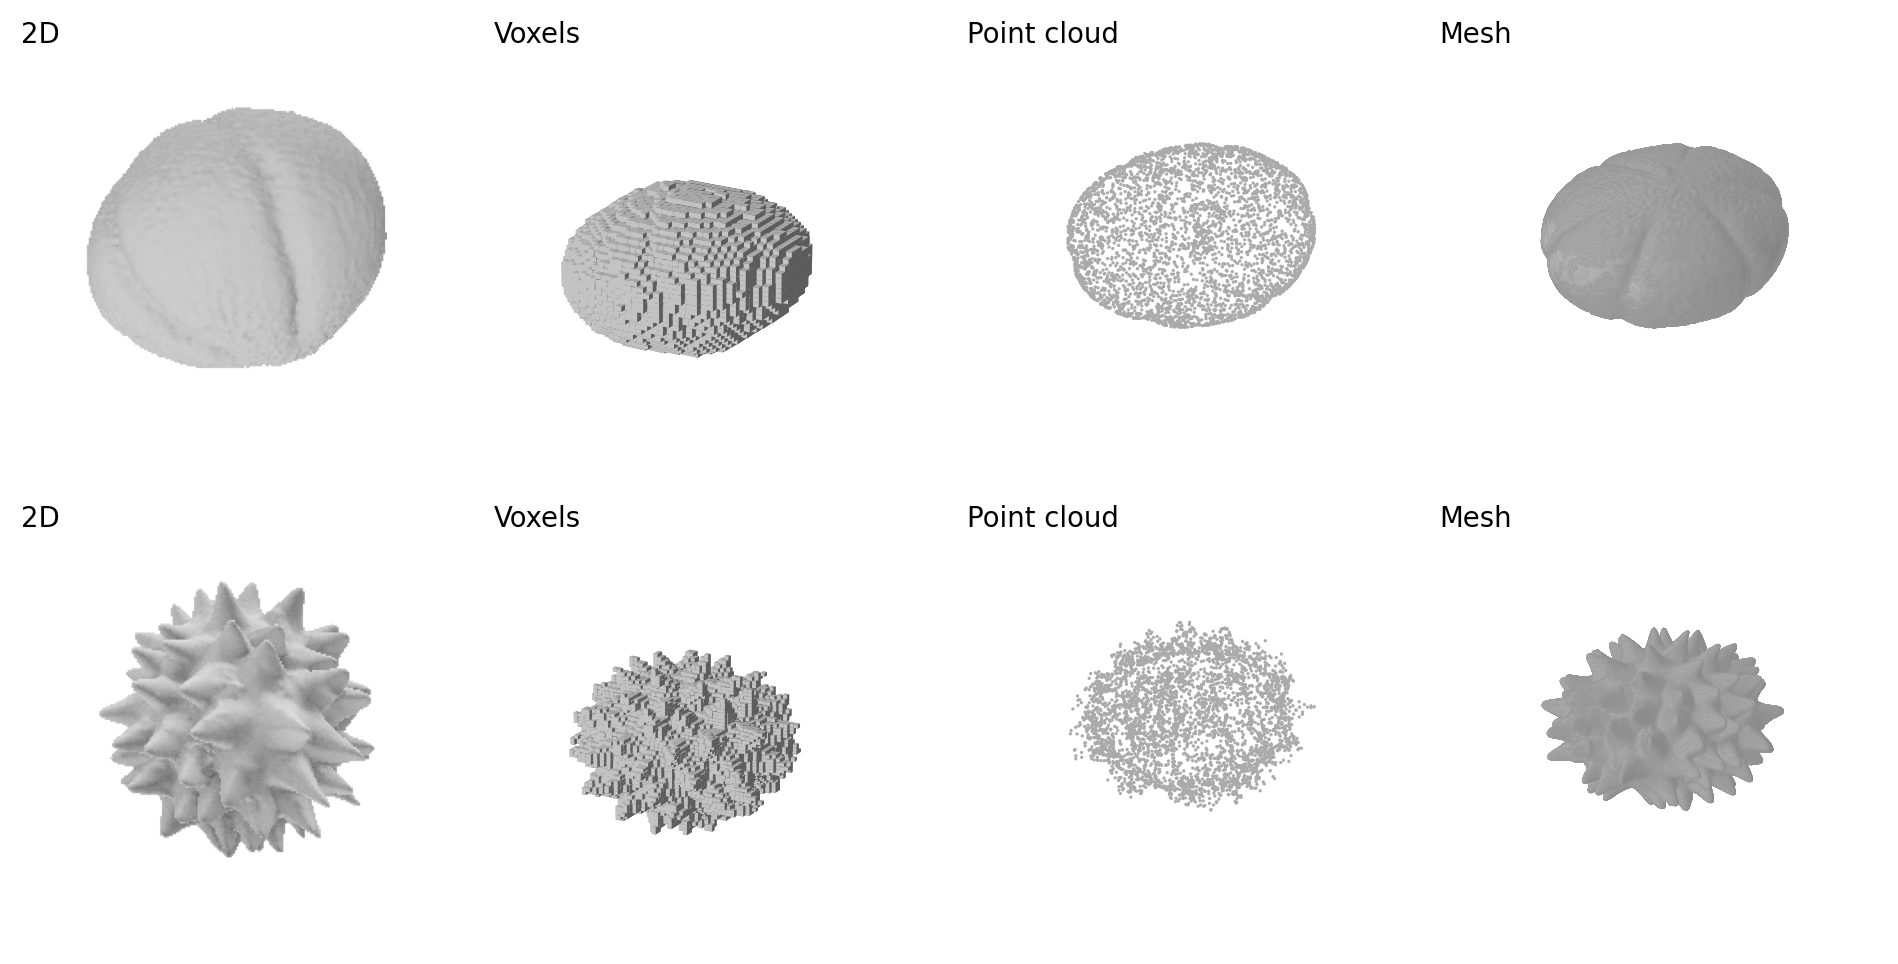

In [18]:
# Create 1x4 figure per object (no axes, transparent background) with corner labels


# Helper to render one row
def render_row(
    fig, row_idx, img, voxels, pc_points, mesh_vertices, mesh_faces, view=(20, -60)
):
    base = 4 * (row_idx - 1)

    # 1) 2D image
    ax1 = fig.add_subplot(2, 4, base + 1)
    if img is not None:
        ax1.imshow(img)
        ax1.set_axis_off()
        add_label(ax1, "2D", color="black")
    else:
        ax1.text(0.5, 0.5, "Image not found", ha="center", va="center")
        ax1.set_axis_off()

    # 2) Voxels
    ax2 = fig.add_subplot(2, 4, base + 2, projection="3d")
    if voxels is not None and np.any(voxels):
        plot_voxels(
            ax2,
            voxels,
            max_cubes=60000,
            color="#DDDDDD",
            edge_color=(0, 0, 0, 0),
            hide_axes=True,
        )
        ax2.view_init(*view)
        add_label(ax2, "Voxels", color="black")
    else:
        ax2.text2D(0.5, 0.5, "Voxels not found", transform=ax2.transAxes, ha="center")
        ax2.set_axis_off()

    # 3) Point cloud
    ax3 = fig.add_subplot(2, 4, base + 3, projection="3d")
    if pc_points is not None and len(pc_points) > 0:
        pts = np.asarray(pc_points)
        if pts.ndim > 2:
            pts = pts.reshape(-1, 3)
        # Helles Grau für Punkte, leicht größer für Sichtbarkeit auf weißem Hintergrund
        plot_point_cloud(ax3, pts, color="#AAAAAA", s=1.0, alpha=0.95, hide_axes=True)
        ax3.view_init(*view)
        add_label(ax3, "Point cloud", color="black")
    else:
        ax3.text2D(
            0.5, 0.5, "Point cloud not found", transform=ax3.transAxes, ha="center"
        )
        ax3.set_axis_off()

    # 4) Mesh via VTK/PyVista offscreen render -> imshow
    ax4 = fig.add_subplot(2, 4, base + 4)
    if mesh_vertices is not None and mesh_faces is not None:
        if pv is not None:
            try:
                img_rgba = mesh_image_vtk(
                    mesh_vertices,
                    mesh_faces,
                    elev=view[0],
                    azim=view[1],
                    image_size=(900, 900),
                    face_color="#EEEEEE",
                    smooth_shading=True,
                    show_edges=True,
                    edge_color="#888888",
                    edge_width=0.4,
                    max_faces=150_000,
                )
                ax4.imshow(img_rgba)
                ax4.set_axis_off()
                add_label(ax4, "Mesh", color="black")
            except Exception as e:
                # Fallback to Matplotlib mesh surface if VTK fails
                ax4.remove()
                ax4 = fig.add_subplot(2, 4, base + 4, projection="3d")
                trisurf = ax4.plot_trisurf(
                    mesh_vertices[:, 0],
                    mesh_vertices[:, 1],
                    mesh_vertices[:, 2],
                    triangles=mesh_faces,
                    color="#EEEEEE",
                    linewidth=0.15,
                    edgecolor="#999999",
                    antialiased=True,
                    shade=True,
                )
                ax4.view_init(*view)
                set_equal_aspect_3d(ax4)
                _clean_3d_axes(ax4, hide_axes=True)
                add_label(ax4, "Mesh", color="black")
        else:
            # No PyVista available -> Matplotlib surface fallback
            ax4.remove()
            ax4 = fig.add_subplot(2, 4, base + 4, projection="3d")
            trisurf = ax4.plot_trisurf(
                mesh_vertices[:, 0],
                mesh_vertices[:, 1],
                mesh_vertices[:, 2],
                triangles=mesh_faces,
                color="#EEEEEE",
                linewidth=0.15,
                edgecolor="#999999",
                antialiased=True,
                shade=True,
            )
            ax4.view_init(*view)
            set_equal_aspect_3d(ax4)
            _clean_3d_axes(ax4, hide_axes=True)
            add_label(ax4, "Mesh", color="black")
    else:
        ax4.text(0.5, 0.5, "Mesh not found", ha="center", va="center")
        ax4.set_axis_off()


# Figure with two rows (object 1 and object 2)
fig = plt.figure(figsize=(16, 8))
fig.patch.set_alpha(0.0)

# Row 1: Thyme object
render_row(fig, 1, img, voxels, pc_points, mesh_vertices, mesh_faces)

# Row 2: Daisy object
render_row(fig, 2, img2, voxels2, pc_points2, mesh2_vertices, mesh2_faces)

fig.subplots_adjust(
    left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.02, hspace=0.06
)

# Save with transparent background
out_dir = Path("figures")
out_dir.mkdir(parents=True, exist_ok=True)

png_path = out_dir / "representation_rows_1x4_each.png"
pdf_path = out_dir / "representation_rows_1x4_each.pdf"
fig.savefig(png_path, transparent=True, bbox_inches="tight", pad_inches=0)
fig.savefig(pdf_path, transparent=True, bbox_inches="tight", pad_inches=0)

print("Saved:", png_path.resolve())
print("Saved:", pdf_path.resolve())

In [15]:
# Override: brighter mesh rendering with lights and two-sided lighting for PyVista
try:
    import numpy as _np
    import pyvista as _pv
except Exception:
    _pv = None


def mesh_image_vtk(
    vertices: _np.ndarray,
    faces: _np.ndarray,
    elev: float = 20.0,
    azim: float = -60.0,
    image_size=(900, 900),
    face_color="#D9D9D9",
    smooth_shading=True,
    show_edges=True,
    edge_color="#555555",
    edge_width=0.4,
    max_faces: int = 150_000,
):
    """Render a mesh with PyVista/VTK offscreen and return an RGBA image (numpy array).
    This override adds:
    - auto-oriented normals
    - two-sided lighting
    - key/fill/rim lights
    - slightly lighter default face color
    """
    if _pv is None:
        raise RuntimeError("PyVista/VTK not available")

    verts = _np.asarray(vertices)
    fcs = _np.asarray(faces)
    if fcs.ndim != 2 or fcs.shape[1] != 3:
        raise ValueError("Faces must be triangular (M,3)")

    # Downsample faces for speed if needed
    if fcs.shape[0] > max_faces:
        rng = _np.random.default_rng(0)
        sel = rng.choice(fcs.shape[0], size=max_faces, replace=False)
        fcs = fcs[sel]

    # Build PyVista mesh: faces need a leading 3 per face and flattened
    fcs_pv = _np.hstack(
        [_np.full((fcs.shape[0], 1), 3, dtype=_np.int64), fcs.astype(_np.int64)]
    )
    fcs_pv = fcs_pv.ravel()
    mesh = _pv.PolyData(verts, fcs_pv)

    # Compute normals and orient them consistently to avoid dark/backface issues
    try:
        mesh = mesh.compute_normals(auto_orient_normals=True, feature_angle=120.0)
    except Exception:
        pass

    plotter = _pv.Plotter(
        off_screen=True, window_size=(int(image_size[0]), int(image_size[1]))
    )
    plotter.set_background("white")
    plotter.enable_anti_aliasing("fxaa")

    # Camera from bounds + elev/azim similar to Matplotlib
    xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
    cx, cy, cz = (0.5 * (xmin + xmax), 0.5 * (ymin + ymax), 0.5 * (zmin + zmax))
    size = max(xmax - xmin, ymax - ymin, zmax - zmin)
    radius = 0.5 * size if size > 0 else 1.0
    dist = 2.2 * radius

    er = _np.deg2rad(elev)
    ar = _np.deg2rad(azim)
    cam_pos = (
        cx + dist * _np.cos(er) * _np.cos(ar),
        cy + dist * _np.cos(er) * _np.sin(ar),
        cz + dist * _np.sin(er),
    )
    plotter.camera_position = [cam_pos, (cx, cy, cz), (0, 0, 1)]

    # Softer edges and proper lighting, disable culling, enable two-sided lighting
    try:
        plotter.enable_two_sided_lighting(True)
    except Exception:
        pass

    plotter.add_mesh(
        mesh,
        color=face_color,
        smooth_shading=smooth_shading,
        show_edges=show_edges,
        edge_color=edge_color,
        line_width=edge_width,
        ambient=0.25,
        diffuse=0.75,
        specular=0.15,
        specular_power=20.0,
        metallic=0.0,
        lighting=True,
        culling=False,
    )

    # Add a simple 3-point light rig (key, fill, rim)
    try:
        key = _pv.Light(
            position=(cx + 2 * dist, cy + 1.5 * dist, cz + 1.2 * dist),
            focal_point=(cx, cy, cz),
            color="white",
            intensity=1.0,
        )
        fill = _pv.Light(
            position=(cx - 2 * dist, cy - 1.5 * dist, cz + 0.8 * dist),
            focal_point=(cx, cy, cz),
            color="white",
            intensity=0.6,
        )
        rim = _pv.Light(
            position=(cx, cy, cz + 3 * dist),
            focal_point=(cx, cy, cz),
            color="white",
            intensity=0.4,
        )
        plotter.add_light(key)
        plotter.add_light(fill)
        plotter.add_light(rim)
    except Exception:
        pass

    img = plotter.screenshot(transparent=True)
    plotter.close()

    if getattr(img, "dtype", None) is not _np.uint8:
        img = (_np.clip(img, 0, 1) * 255).astype(_np.uint8)
    return img